In [92]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


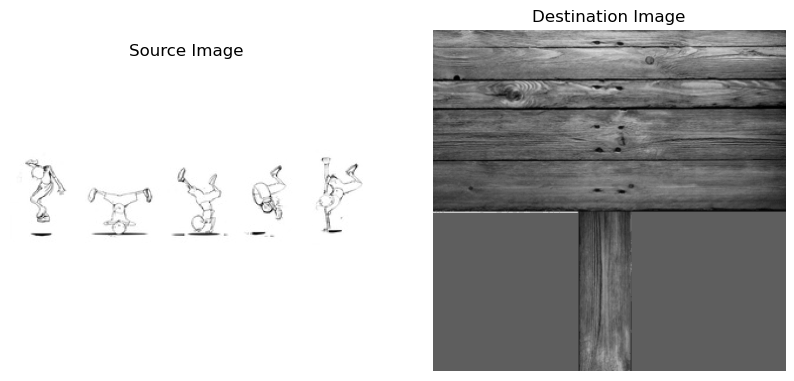

In [93]:
# Setting the paths for the source and target image
img_folder_path = os.path.join(os.getcwd(),"Images Mixed")
src_img_path = os.path.join(img_folder_path, "source.jpg")
target_img_path = os.path.join(img_folder_path, "target.png")

# Storing the images as numpy arrays
src_img = cv2.imread(src_img_path, cv2.IMREAD_GRAYSCALE)
target_img = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the source image
axes[0].imshow(src_img, cmap='grey')
axes[0].set_title('Source Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Plot the destination image
axes[1].imshow(target_img, cmap='grey')
axes[1].set_title('Destination Image')
axes[1].axis('off')

plt.show()

Mask saved as 'polygon_mask.jpg'


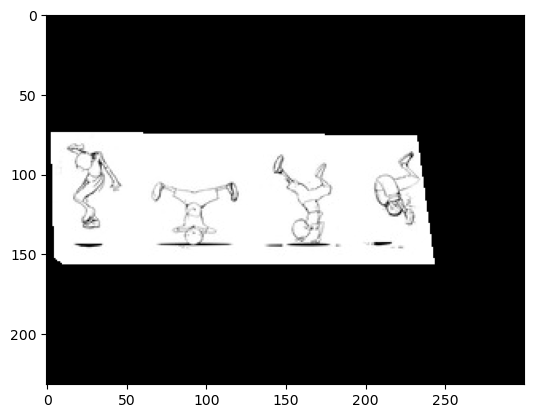

In [94]:
#!python select_region.py "{src_img_path}"

from select_region import RegionSelector
region_select = RegionSelector()
polygon_points = region_select.select_region(src_img_path)
# # Read the saved region coordinates
# with open('selected_polygon.json', 'r') as file:
#     polygon_points = json.load(file)

polygon_points = np.array(polygon_points, dtype=np.int32)

# Create a mask with the same dimensions as the source image
mask = np.zeros_like(src_img)
cv2.fillPoly(mask, [polygon_points], 255)

# Extract the region of interest
selected_region = cv2.bitwise_and(src_img, mask)

mask_img_path = os.path.join(img_folder_path, 'source_mask.jpg')
mask_path = os.path.join(img_folder_path, 'mask.jpg')
cv2.imwrite(mask_img_path, selected_region)
cv2.imwrite(mask_path,mask)
print("Mask saved as 'polygon_mask.jpg'")

# Display the extracted region
plt.imshow(selected_region, cmap='gray')
plt.show()

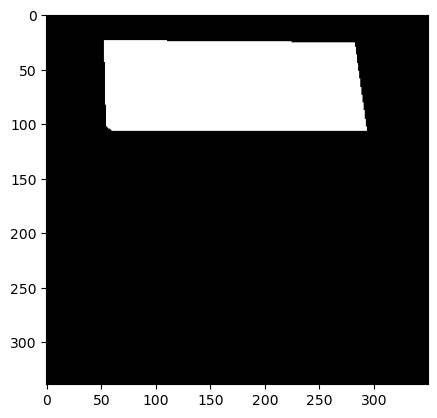

In [95]:
import mask_mover

result_path = os.path.join(img_folder_path,"target_without_region.jpg")

offset = mask_mover.move_mask(target_img_path, polygon_points, result_path)
target_without_region = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
def translate_mask(mask, offset):
    """
    Translate a binary mask by a given offset.
    """
    # Create the translation matrix
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    
    # Translate the mask
    translated_mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    return translated_mask

def pad_array_to_match(target_array, array_to_pad):

    # Calculate the padding required for each dimension
    padding = [(0, max(0, t - s)) for s, t in zip(array_to_pad.shape, target_array.shape)]

    # Pad the array
    padded_array = np.pad(array_to_pad, pad_width=padding, mode='constant', constant_values=0)

    return padded_array

src_mask = pad_array_to_match(target_img, src_img)
src_mask = translate_mask(src_mask, offset)
new_mask = pad_array_to_match(target_img, mask)
new_mask = translate_mask(new_mask, offset)
plt.imshow(new_mask, cmap="grey")
plt.show()


In [96]:
if np.isin(new_mask, [0, 1]).all():
    pass
else:
    # Convert to binary by setting values greater than 0 to 1
    new_mask = np.where(new_mask > 0, 1, 0)

In [97]:
import numpy as np
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix

# Helper enum
OMEGA = 0
DEL_OMEGA = 1
OUTSIDE = 2

# Determine if a given index is inside omega, on the boundary (del omega),
# or outside the omega region
def point_location(index, mask):
    if in_omega(index,mask) == False:
        return OUTSIDE
    if edge(index,mask) == True:
        return DEL_OMEGA
    return OMEGA

# Determine if a given index is either outside or inside omega
def in_omega(index, mask):
    return mask[index] == 1

# Deterimine if a given index is on del omega (boundary)
def edge(index, mask):
    if in_omega(index,mask) == False: return False
    for pt in get_surrounding(index):
        # If the point is inside omega, and a surrounding point is not,
        # then we must be on an edge
        if in_omega(pt,mask) == False: return True
    return False

# Apply the Laplacian operator at a given index
def lapl_at_index(source, index):
    i,j = index
    val = (4 * source[i,j])    \
           - (1 * source[i+1, j]) \
           - (1 * source[i-1, j]) \
           - (1 * source[i, j+1]) \
           - (1 * source[i, j-1])
    return val

# Find the indicies of omega, or where the mask is 1
def mask_indicies(mask):
    nonzero = np.nonzero(mask)
    return list(zip(nonzero[0], nonzero[1]))

# Get indicies above, below, to the left and right
def get_surrounding(index):
    i,j = index
    return [(i+1,j),(i-1,j),(i,j+1),(i,j-1)]

# Create the A sparse matrix
def poisson_sparse_matrix(points):
    # N = number of points in mask
    N = len(points)
    A = lil_matrix((N,N))
    # Set up row for each point in mask
    for i,index in enumerate(points):
        # Should have 4's diagonal
        A[i,i] = 4
        # Get all surrounding points
        for x in get_surrounding(index):
            # If a surrounding point is in the mask, add -1 to index's
            # row at correct position
            if x not in points: continue
            j = points.index(x)
            A[i,j] = -1
    return A

# Mixed Seamless Cloning
def mixed_seamless(s, t, index):
    # Calculate gradients for source and target
    grad_s = lapl_at_index(s, index)
    grad_t = lapl_at_index(t, index)
    #return grad_s * 0.5 + grad_t * 0.5
    # Choose the larger gradient
    if abs(grad_s) > abs(grad_t):
        return grad_s 
    else:
        return grad_t 


# Main method
# Does Poisson image editing on one channel given a source, target, and mask
def process(source, target, mask, mode):
    indicies = mask_indicies(mask)
    N = len(indicies)
    # Create poisson A matrix. Contains mostly 0's, some 4's and -1's
    A = poisson_sparse_matrix(indicies)
    # Create B matrix
    b = np.zeros(N)
    for i,index in enumerate(indicies):
        if mode:
            b[i] = mixed_seamless(source,target,index)
        else:
            # Start with left hand side of discrete equation
            b[i] = lapl_at_index(source, index)

        # If on boundry, add in target intensity
        # Creates constraint lapl source = target at boundary
        if point_location(index, mask) == DEL_OMEGA:
            for pt in get_surrounding(index):
                if in_omega(pt,mask) == False:
                    b[i] += target[pt]
    # Solve for x, unknown intensities
    x = linalg.cg(A, b)
    # Copy target photo, make sure as int
    composite = np.copy(target).astype(int)
    
    # Place new intensity on target at given index
    for i,index in enumerate(indicies):
        composite[index] = int(x[0][i])

    return composite

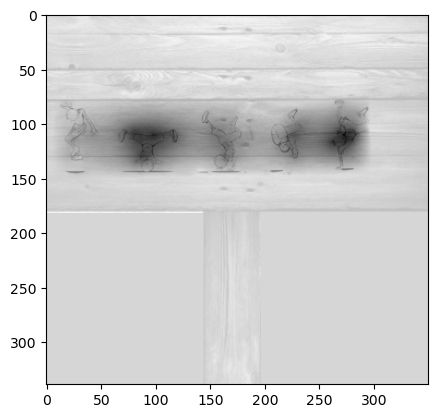

In [86]:
# 0 means seamless poisson, 1 means mixed seamless poisson
blended_image = process(src_mask, target_img, new_mask, 1)
plt.imshow(blended_image, cmap='grey')
plt.show()

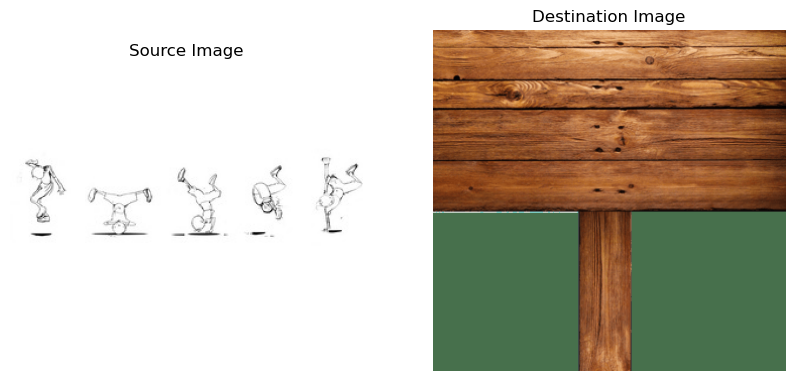

In [87]:
# Storing the images as numpy arrays
src_img = cv2.imread(src_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)

# Convert to RGB
src_img_rgb = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the source image
axes[0].imshow(src_img_rgb)
axes[0].set_title('Source Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Plot the destination image
axes[1].imshow(target_img_rgb)
axes[1].set_title('Destination Image')
axes[1].axis('off')

plt.show()

In [88]:
# 3 Color channels for the source image
src_img_r, src_img_g, src_img_b = cv2.split(src_img_rgb)

# 3 Color channels for the target image 
target_img_r, target_img_g, target_img_b = cv2.split(target_img_rgb)

In [89]:
src_mask_r = pad_array_to_match(target_img, src_img_r)
src_mask_r = translate_mask(src_mask_r, offset)

src_mask_g = pad_array_to_match(target_img, src_img_g)
src_mask_g = translate_mask(src_mask_g, offset)

src_mask_b = pad_array_to_match(target_img, src_img_b)
src_mask_b = translate_mask(src_mask_b, offset)

In [90]:
# Process each channel
R_blended = process(src_mask_r, target_img_r, new_mask, 1)
G_blended = process(src_mask_g, target_img_g, new_mask, 1)
B_blended = process(src_mask_b, target_img_b, new_mask, 1)

# Merge the processed channels back into one image
blended_image = cv2.merge([R_blended, G_blended, B_blended])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


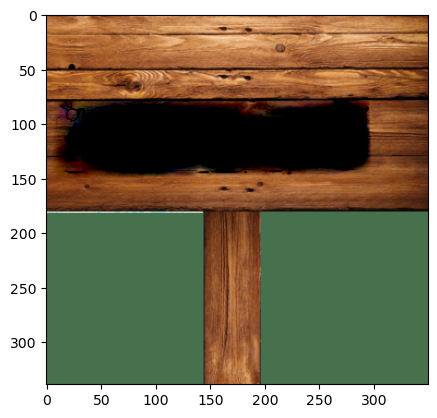

In [91]:
# Display the blended image
plt.imshow(blended_image)
plt.show()